# 00_ 01匯入資料並02整理成一張dataframe (請直接執行)

## 01_import dataset

### 01-1_import data

In [7]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


### 01-2_rename variable in each data set

In [8]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




### 01-3_變數型態統一及缺失值處理

In [9]:
def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

In [10]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = 20000 #原本是-1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(10000) #原本是-999
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [11]:
#cars one hot encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_use = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_use], axis=1)

#gender 原始種類：Female_51%, Male_49%
dummies_gender = pd.get_dummies(users_df['gender'], prefix='gender', dtype='uint8')
users_df = pd.concat([users_df, dummies_gender], axis=1)


cards_df.drop(columns=["has_chip_NO","has_chip"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)
users_df.drop(columns=["gender_Female"], inplace=True)

## 02_資料整併成一張dataframe

### 02-1_資料整併

In [12]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

## 合併完之後最後處理is_fraud(原會有missing values問題)
merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])

#merged.to_csv("merged.csv", index=False)

# 先刪除不需要的DataFrame以節省記憶體
del transactions_df, users_df, cards_df, train_fraud_labels_df, cols_to_encode, dummies_cards, dummies_use, dummies_gender

In [13]:
#backup_merged = merged.copy()

# 04_RFM + DK 重點微調

In [8]:
#merged = backup_merged.copy() ##有出事再趕快回復原狀

## 04_RFM features engineering model

### 04-1_RFM features 新增

In [14]:
import numpy as np
import pandas as pd

# 確保日期是 datetime 並排序
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.sort_values(by=['client_id_x', 'date']).reset_index(drop=True)

# --- RecencyInterval ---
merged['RecencyInterval'] = merged.groupby('client_id_x')['date'].diff().dt.total_seconds().fillna(0)/60

# --- TxnFrequency for multiple windows (向量化滑動窗口) ---
window_days = [7, 30, 60, 90]
for w in window_days:
    merged[f'TxnFrequency_{w}d'] = 0

def compute_freq_vectorized(dates, windows):
    """向量化計算每筆交易在每個 window 內的交易數"""
    n = len(dates)
    dates_int = dates.values.astype('datetime64[D]').astype(int)
    res = {w: np.zeros(n, dtype=int) for w in windows}
    for w in windows:
        left = 0
        counts = np.zeros(n, dtype=int)
        for right in range(n):
            while dates_int[right] - dates_int[left] > w:
                left += 1
            counts[right] = right - left + 1
        res[w] = counts
    return res

# 分組計算
for cid, g in merged.groupby('client_id_x', sort=False):
    freq_dict = compute_freq_vectorized(g['date'], window_days)
    for w in window_days:
        merged.loc[g.index, f'TxnFrequency_{w}d'] = freq_dict[w]

# --- AmtDelta ---
merged['prev_amount'] = merged.groupby('client_id_x')['amount'].shift(1)
merged['AmtDelta'] = merged['amount'] - merged['prev_amount']
merged['AmtDelta'] = merged['AmtDelta'].fillna(0)
merged.drop(columns='prev_amount', inplace=True)

### 04-3_DK features 新增

In [15]:
# US region mapping
us_region_map = {
    'Northeast': ['NY','NJ','PA','MA','CT','RI','NH','VT','ME'],
    'Midwest': ['IL','OH','MI','IN','WI','MN','IA','MO','ND','SD','NE','KS'],
    'South': ['FL','GA','SC','NC','AL','MS','LA','TX','OK','TN','KY','VA','WV','AR','MD','DE','DC'],
    'West': ['CA','WA','OR','NV','AZ','NM','CO','UT','ID','MT','WY','AK','HI'],
}
continent_map = {
    'Europe': [ ... ],  # 原本 continent_map['Europe'] 可直接使用
    'Online': ['online','AA']
}

us_region_lookup = {state: region for region, states in us_region_map.items() for state in states}

# --- 向量化 location 特徵 ---
merged['merchant_online'] = merged['merchant_state'].eq('online').astype('uint8')
merged['merchant_us'] = merged['merchant_state'].isin(us_region_lookup.keys()).astype('uint8')
merged['merchant_eu'] = merged['merchant_state'].isin(continent_map['Europe']).astype('uint8')
merged['merchant_others'] = (~merged[['merchant_online','merchant_us','merchant_eu']].any(axis=1)).astype('uint8')

# --- 首次交易標記 ---
merged['FirstTxnInRegion'] = (~merged.duplicated(subset=['client_id_x', 'merchant_state'])).astype('uint8')

# DifferentState
merged['prev_state']=(merged
                     .groupby('client_id_x')['merchant_state']
                     .shift(1))

merged['DifferentState'] = (
    (merged['merchant_state'] != merged['prev_state'])
    & merged['prev_state'].notna()
).astype(int)

merged = merged.drop(columns=['prev_state'])


### 04-3_資料進行變數轉換以求模型配飾更佳表現(不一樣)

In [16]:
#merged[["card_id","card_number"]]
import numpy as np
from scipy import stats 

# === (1) log轉換 ===
merged['amount'] = np.where(merged['amount'] < 0, 0, merged['amount'])  # 負數變 0
merged['amount'] = np.log(merged['amount'] + 1)  

# === (3) 平方根轉換 ===
merged['credit_limit']=np.sqrt(merged['credit_limit'])
merged['total_debt']=np.sqrt(merged['total_debt'])

# === (3) 立方根轉換 ===
merged['yearly_income']=np.cbrt(merged['yearly_income'])
merged['per_capita_income']=np.cbrt(merged['per_capita_income'])

## Box-Cox Transformation
###merged['yearly_income'], fitted_lambda = stats.boxcox(merged['yearly_income'])

# === (5) Yeo–Johnson 轉換（可處理負值） ===
###merged['per_capita_income'], lambdaValue =stats.yeojohnson(merged['per_capita_income'])

### 04-4_分割訓練集及測試集、不同block 並從這裡才計算 HighRiskMCC 避免資料洩漏

In [17]:
# --- 選取數值型變數 ---
num_cols = merged.select_dtypes(include=['int64', 'float64','uint8','datetime64[ns]']).columns
df2 = merged[num_cols]

# --- dropna ---
df_cleaned = df2.dropna()
del df2

# --- 避免共線性 ---
df_cleaned.drop(columns=["is_fraud_missing_flag","card_type_Debit (Prepaid)", 
                         "card_brand_Discover", "use_chip_Online Transaction"], inplace=True)

# --- 確保 date 欄位在 df_cleaned 中 ---
if 'date' not in df_cleaned.columns:
    df_cleaned['date'] = merged.loc[df_cleaned.index, 'date']

# --- 依時間排序 ---
df_sorted = df_cleaned.sort_values('date')
df_sorted['year'] = df_sorted['date'].dt.year

# 2010–2011 → block 0
# 2012–2013 → block 1
# ...
# 2018–2019 → block 4（如果你真的是 2010–2019 共 10 年，會有 5 個 block）
df_sorted['time_block'] = (df_sorted['year'] - 2010) // 1


#對每個時間block做切割
train_list = []
test_list = []

for block_id, block_df in df_sorted.groupby('time_block'):
    print(f"\nProcessing Block {block_id}")

    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)

    train_block = block_df.iloc[:split_index].copy()
    test_block  = block_df.iloc[split_index:].copy()

    # -----------------------------
    # 1️⃣ 用「該 block 的 train」算 fraud rate
    # -----------------------------
    fraud_rate = (
        train_block
        .groupby('mcc_code')['is_fraud']
        .mean()
    )

    high_risk_mcc = fraud_rate[fraud_rate > 0.02].index

    # -----------------------------
    # 2️⃣ 套用到該 block 的 train / test
    # -----------------------------
    train_block['HighRiskMCC'] = train_block['mcc_code'].isin(high_risk_mcc).astype('uint8')
    test_block['HighRiskMCC']  = test_block['mcc_code'].isin(high_risk_mcc).astype('uint8')

    train_list.append(train_block)
    test_list.append(test_block)


train_df = pd.concat(train_list).drop(columns=['date', 'year', 'time_block'])
test_df  = pd.concat(test_list).drop(columns=['date', 'year', 'time_block'])


#比例檢查
for block_id in sorted(df_sorted['time_block'].unique()):
    print(f"\nBlock {block_id}")
    print("Train fraud count:")
    print(train_df.loc[df_sorted['time_block'] == block_id, 'is_fraud'].value_counts())
    print("Test fraud count:")
    print(test_df.loc[df_sorted['time_block'] == block_id, 'is_fraud'].value_counts())





Processing Block 0

Processing Block 1

Processing Block 2

Processing Block 3

Processing Block 4

Processing Block 5

Processing Block 6

Processing Block 7

Processing Block 8

Processing Block 9

Block 0
Train fraud count:
is_fraud
0    663110
1      2113
Name: count, dtype: Int64
Test fraud count:
is_fraud
0    165846
1       460
Name: count, dtype: Int64

Block 1
Train fraud count:
is_fraud
0    690705
1        37
Name: count, dtype: Int64
Test fraud count:
is_fraud
0    172686
Name: count, dtype: Int64

Block 2
Train fraud count:
is_fraud
0    707413
1       923
Name: count, dtype: Int64
Test fraud count:
is_fraud
0    177085
Name: count, dtype: Int64

Block 3
Train fraud count:
is_fraud
0    725007
1       836
Name: count, dtype: Int64
Test fraud count:
is_fraud
0    180960
1       501
Name: count, dtype: Int64

Block 4
Train fraud count:
is_fraud
0    731394
1       664
Name: count, dtype: Int64
Test fraud count:
is_fraud
0    183015
Name: count, dtype: Int64

Block 5
Train f

### 04-5_定義不同的features group 方便模型運算

In [18]:
'''
result = pd.DataFrame(columns=[
    "Model", "Features", 
    "Train AUC", "Test AUC", 
    "Train PR AUC", "Test PR AUC"
])

'''

# ALL features

all_cols = ['transaction_id', 'date', 'client_id_x', 'card_id', 'amount',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc_code',
       'errors', 'merchant_state_missing_flag', 'zip_missing_flag',
       'errors_missing_flag', 'use_chip_Chip Transaction',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction',
       'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
       'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'gender_Male', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'card_type_Credit',
       'card_type_Debit', 'card_type_Debit (Prepaid)', 'card_brand_Amex',
       'card_brand_Discover', 'card_brand_Mastercard', 'card_brand_Visa',
       'has_chip_YES', 'is_fraud_missing_flag']

VIF_col = ["is_fraud_missing_flag","card_type_Debit (Prepaid)", 
                         "card_brand_Discover", "use_chip_Online Transaction",'is_fraud_missing_flag','merchant_state_missing_flag', 'zip_missing_flag','card_on_dark_web','errors_missing_flag']

identifier = [
    'transaction_id',
    'client_id_x',
    'card_id',
    'card_number',
    'cvv'
]

leakage_cols = ['latitude', 'longitude', 'zip','merchant_id','mcc_code'] #gemini建議


set_VIF = set(VIF_col)
set_identifier =set(identifier)
exclude_cols = set(VIF_col) | set(identifier)| set(leakage_cols)
all_cols = [x for x in all_cols if x not in exclude_cols]


# RFM features
rfm_cols = [
    'RecencyInterval', 'TxnFrequency_7d','TxnFrequency_30d',
    'TxnFrequency_60d', 'TxnFrequency_90d','AmtDelta'
]

# DK features
dk_cols = [
    'merchant_online', 'merchant_us', 'merchant_eu', 'merchant_others',
    'FirstTxnInRegion','HighRiskMCC','DifferentState'
]

# Grouping
feature_groups = {
    "X_all": all_cols,
    "X_rfm": rfm_cols,
    "X_dk": dk_cols,
    "X_all + X_rfm": all_cols + rfm_cols,
    "X_all + X_dk": all_cols + dk_cols,
    "X_rfm + X_dk": rfm_cols + dk_cols,
    "X_all + X_rfm + X_dk": all_cols + rfm_cols + dk_cols
}

### 04-6_Assumption: Avoid Multicollinearity（老師建議我們先省略）

In [14]:
'''
##處理高度共線性變數
train_df.drop(columns=["per_capita_income"], inplace=True)
train_df.drop(columns=["use_chip_Chip Transaction","merchant_state_missing_flag","zip_missing_flag"], inplace=True)           
train_df.drop(columns=["card_brand_Visa" ,"card_brand_Amex","card_type_Credit"], inplace=True)

test_df.drop(columns=["per_capita_income"], inplace=True)
test_df.drop(columns=["use_chip_Chip Transaction","merchant_state_missing_flag","zip_missing_flag"], inplace=True)           
test_df.drop(columns=["card_brand_Visa" ,"card_brand_Amex","card_type_Credit"], inplace=True)
'''

'\n##處理高度共線性變數\ntrain_df.drop(columns=["per_capita_income"], inplace=True)\ntrain_df.drop(columns=["use_chip_Chip Transaction","merchant_state_missing_flag","zip_missing_flag"], inplace=True)           \ntrain_df.drop(columns=["card_brand_Visa" ,"card_brand_Amex","card_type_Credit"], inplace=True)\n\ntest_df.drop(columns=["per_capita_income"], inplace=True)\ntest_df.drop(columns=["use_chip_Chip Transaction","merchant_state_missing_flag","zip_missing_flag"], inplace=True)           \ntest_df.drop(columns=["card_brand_Visa" ,"card_brand_Amex","card_type_Credit"], inplace=True)\n'

# 05_Features Selection 部分

## 05-1_Stepwise selection

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings

# 忽略 statsmodels 可能產生的迭代警告，保持輸出乾淨
warnings.filterwarnings("ignore")

# ===========================================================
# 1. 核心函數：嚴謹版 Stepwise (Forward + Backward)
# ===========================================================

def check_data_validity(y_data, stage="Train"):
    """檢查資料是否足夠進行 Logistic Regression"""
    if len(y_data) == 0:
        return False, f"{stage} set is empty"
    if y_data.nunique() < 2:
        val = y_data.iloc[0] if len(y_data) > 0 else "None"
        return False, f"{stage} set has only 1 class (value: {val})"
    return True, ""

def run_stepwise_logit(train_df, test_df, feature_cols, dep_var="is_fraud", 
                       threshold_in=0.01, threshold_out=0.05, max_iter=50):
    """
    Stepwise Selection based on P-values (Forward Selection + Backward Elimination)
    """
    # --- 1. 準備數據 ---
    X_train = train_df[feature_cols].fillna(0)
    y_train = train_df[dep_var]
    X_test  = test_df[feature_cols].fillna(0)
    y_test  = test_df[dep_var]

    # --- 2. 防崩潰檢查 (Edge Case Handling) ---
    is_valid_train, msg_train = check_data_validity(y_train, "Train")
    if not is_valid_train:
        return {"status": "skip", "message": msg_train}
    
    # 測試集若無效，模型仍可訓練，只是無法算 Test AUC
    is_valid_test, _ = check_data_validity(y_test, "Test")

    # --- 3. 標準化 (Standardization) ---
    # Logistic 對變數尺度極其敏感，Stepwise 前務必標準化
    try:
        scaler = StandardScaler()
        X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=train_df.index)
        X_test_std  = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=test_df.index)
    except Exception as e:
        return {"status": "error", "message": f"Scaling failed: {str(e)}"}

    # --- 4. 迭代篩選 ---
    included = []
    candidates = list(feature_cols)

    for i in range(max_iter):
        changed = False
        
        # ====== Forward Step: 嘗試加入一個最好的變數 ======
        best_pval = 1.0
        best_feature = None
        
        for candidate in candidates:
            try:
                # 暫時加入候選變數
                current_vars = included + [candidate]
                X_const = sm.add_constant(X_train_std[current_vars])
                
                # 訓練 (disp=0 不印出 log)
                model = sm.Logit(y_train, X_const).fit(disp=0, method='newton')
                
                # 取得該變數的 p-value
                pval = model.pvalues[candidate]
                
                if pval < best_pval:
                    best_pval = pval
                    best_feature = candidate
            except:
                # 若發生 Singular Matrix (矩陣奇異) 或收斂失敗，跳過該變數
                continue
        
        # 若 P-value 小於門檻則加入
        if best_feature is not None and best_pval < threshold_in:
            included.append(best_feature)
            candidates.remove(best_feature)
            changed = True
            # print(f"    + Add: {best_feature} (p={best_pval:.4f})")

        # ====== Backward Step: 嘗試移除一個最差的變數 ======
        if included:
            try:
                X_const = sm.add_constant(X_train_std[included])
                model = sm.Logit(y_train, X_const).fit(disp=0)
                
                # 找出 p-value 最大的變數 (排除 const)
                pvalues = model.pvalues.drop('const', errors='ignore')
                if not pvalues.empty:
                    worst_pval = pvalues.max()
                    worst_feature = pvalues.idxmax()
                    
                    # 若 P-value 大於門檻則移除
                    if worst_pval > threshold_out:
                        included.remove(worst_feature)
                        candidates.append(worst_feature)
                        changed = True
                        # print(f"    - Drop: {worst_feature} (p={worst_pval:.4f})")
            except:
                pass

        if not changed:
            break

    # --- 5. 最終結果回傳 ---
    if not included:
        return {"status": "skip", "message": "No variables selected (all insignificant)"}

    # 計算當下 Stepwise 模型的 Metrics (供參考)
    try:
        X_train_final = sm.add_constant(X_train_std[included])
        final_model = sm.Logit(y_train, X_train_final).fit(disp=0)
        
        train_prob = final_model.predict(X_train_final)
        train_auc = roc_auc_score(y_train, train_prob)
        train_pr  = average_precision_score(y_train, train_prob)
        
        test_auc = np.nan
        test_pr = np.nan
        
        if is_valid_test:
            try:
                X_test_final = sm.add_constant(X_test_std[included])
                test_prob = final_model.predict(X_test_final)
                test_auc = roc_auc_score(y_test, test_prob)
                test_pr  = average_precision_score(y_test, test_prob)
            except:
                pass

        return {
            "status": "success",
            "selected_features": included,  # <--- 重點：選出的變數列表
            "metrics": {
                "Train AUC": round(train_auc, 4),
                "Test AUC": round(test_auc, 4) if not np.isnan(test_auc) else np.nan,
                "Train PR-AUC": round(train_pr, 4),
                "Test PR-AUC": round(test_pr, 4) if not np.isnan(test_pr) else np.nan,
                "Num Features": len(included)
            }
        }
    except Exception as e:
        return {"status": "error", "message": str(e)}


# ===========================================================
# 2. 設定與特徵群組
# ===========================================================

# 確保 df_sorted 存在
if 'df_sorted' not in locals():
    raise ValueError("⚠️ Error: 'df_sorted' 未定義，請先載入您的資料。")

# 定義要排除的欄位
identifier = ['transaction_id', 'client_id_x', 'card_id', 'card_number', 'cvv']
exclude_cols = set(identifier) | {'is_fraud', 'date', 'year', 'time_block', 'HighRiskMCC'}

def clean_cols(cols):
    """過濾掉 ID 與 Target 等不應放入模型的欄位"""
    return [c for c in cols if c not in exclude_cols]

# 定義您的 Feature Groups
# (假設 all_cols, rfm_cols, dk_cols 變數已存在於您的環境中)
feature_groups = {
    "X_all": clean_cols(all_cols),
    "X_rfm": clean_cols(rfm_cols),
    "X_dk": clean_cols(dk_cols),
    "X_all + X_rfm": clean_cols(all_cols + rfm_cols),
    "X_all + X_dk": clean_cols(all_cols + dk_cols),
    "X_rfm + X_dk": clean_cols(rfm_cols + dk_cols),
    "X_all + X_rfm + X_dk": clean_cols(all_cols + rfm_cols + dk_cols)
}


# ===========================================================
# 3. 主執行迴圈 (儲存變數 + 產出初步報表)
# ===========================================================

# ★ 這是最重要的儲存容器：[Block ID][Group Name] -> [變數列表]
stepwise_feature_storage = {} 
stepwise_report_list = []

for block_id, block_df in df_sorted.groupby('time_block'):
    
    current_year = 2010 + block_id
    print(f"\n{'='*60}")
    print(f"🧩 Stepwise Selection for Block {block_id} (Year: {current_year})")
    print(f"{'='*60}")

    # --- 1. 時間序列切分 (Temporal Split) ---
    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)
    
    train_raw = block_df.iloc[:split_index].copy()
    test_raw  = block_df.iloc[split_index:].copy()

    # --- 2. 特徵工程 (Anti-Leakage) ---
    # 必須在切分後才做 Risk 計算
    try:
        fraud_rate = train_raw.groupby('mcc_code')['is_fraud'].mean()
        high_risk_mcc = fraud_rate[fraud_rate > 0.02].index
        train_raw['HighRiskMCC'] = train_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
        test_raw['HighRiskMCC']  = test_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
    except:
        pass # 若 train 空了會被後面的 check 擋下，這裡忽略

    # 初始化該年份的儲存空間
    stepwise_feature_storage[block_id] = {}

    # --- 3. 針對每個 Group 跑 Stepwise ---
    for group_name, feature_list in feature_groups.items():
        
        # 確保特徵存在
        valid_features = [f for f in feature_list if f in train_raw.columns]
        if not valid_features:
            continue
            
        print(f"   🔸 Group: {group_name} (Pool: {len(valid_features)})...", end=" ")

        # 執行 Stepwise
        res = run_stepwise_logit(
            train_raw, 
            test_raw, 
            feature_cols=valid_features,
            threshold_in=0.01,   # 顯著才入選
            threshold_out=0.05   # 不顯著就踢除
        )

        # 處理結果
        if res["status"] == "success":
            m = res["metrics"]
            selected_feats = res["selected_features"]
            
            print(f"✅ Selected {len(selected_feats)} feats | Test AUC: {m['Test AUC']}")
            
            # (A) 存變數 (給後續模型用)
            stepwise_feature_storage[block_id][group_name] = selected_feats
            
            # (B) 存報表數據
            row = {
                "Year": current_year,
                "Feature Group": group_name,
                "Train AUC": m["Train AUC"], "Test AUC": m["Test AUC"],
                "Train PR-AUC": m["Train PR-AUC"], "Test PR-AUC": m["Test PR-AUC"],
                "Num Features": m["Num Features"]
            }
            stepwise_report_list.append(row)
            
        elif res["status"] == "skip":
            print(f"⚠️ Skipped: {res['message']}")
            stepwise_feature_storage[block_id][group_name] = [] # 存空 list
            # 存 NaN 報表
            row = {
                "Year": current_year, "Feature Group": group_name,
                "Train AUC": np.nan, "Test AUC": np.nan,
                "Train PR-AUC": np.nan, "Test PR-AUC": np.nan,
                "Num Features": 0
            }
            stepwise_report_list.append(row)
            
        else:
            print(f"❌ Error: {res['message']}")
            stepwise_feature_storage[block_id][group_name] = []

print("\n🎉 Stepwise Selection Completed!")
print(f"變數結果已儲存於 'stepwise_feature_storage' 字典中。")


# ===========================================================
# 4. 顯示 Stepwise 初步結果報表
# ===========================================================
if stepwise_report_list:
    df_sw_raw = pd.DataFrame(stepwise_report_list)
    
    # 轉置表格 (Pivot) 以符合您習慣的格式
    target_metrics = ["Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]
    df_sw_pivot = df_sw_raw.pivot(index="Feature Group", columns="Year", values=target_metrics)
    
    # 調整欄位順序
    df_sw_pivot.columns = df_sw_pivot.columns.swaplevel(0, 1)
    unique_years = sorted(df_sw_raw["Year"].unique())
    ordered_columns = [(y, m) for y in unique_years for m in target_metrics]
    
    df_sw_final = df_sw_pivot.reindex(columns=ordered_columns)
    
    print("\n=== Stepwise Logistic Regression 變數篩選成效表 ===")
    print(df_sw_final.to_string())
else:
    print("No data to report.")


🧩 Stepwise Selection for Block 0 (Year: 2010)
   🔸 Group: X_all (Pool: 19)... ✅ Selected 6 feats | Test AUC: 0.9164
   🔸 Group: X_rfm (Pool: 6)... ✅ Selected 4 feats | Test AUC: 0.7408
   🔸 Group: X_dk (Pool: 6)... ✅ Selected 4 feats | Test AUC: 0.9654
   🔸 Group: X_all + X_rfm (Pool: 25)... ✅ Selected 10 feats | Test AUC: 0.9411
   🔸 Group: X_all + X_dk (Pool: 25)... ✅ Selected 8 feats | Test AUC: 0.917
   🔸 Group: X_rfm + X_dk (Pool: 12)... ✅ Selected 7 feats | Test AUC: 0.9295
   🔸 Group: X_all + X_rfm + X_dk (Pool: 31)... ✅ Selected 12 feats | Test AUC: 0.9768

🧩 Stepwise Selection for Block 1 (Year: 2011)
   🔸 Group: X_all (Pool: 19)... ✅ Selected 2 feats | Test AUC: nan
   🔸 Group: X_rfm (Pool: 6)... ✅ Selected 1 feats | Test AUC: nan
   🔸 Group: X_dk (Pool: 6)... ✅ Selected 2 feats | Test AUC: nan
   🔸 Group: X_all + X_rfm (Pool: 25)... ✅ Selected 7 feats | Test AUC: nan
   🔸 Group: X_all + X_dk (Pool: 25)... ✅ Selected 3 feats | Test AUC: nan
   🔸 Group: X_rfm + X_dk (Pool: 12

In [ ]:
## stepwise變數選取 結果

import pickle

# 1. 儲存 (Save)
with open('stepwise_feature_storage.pkl', 'wb') as f:
    pickle.dump(stepwise_feature_storage, f)

print("✅ 已成功儲存為 stepwise_feature_storage.pkl")

# ==========================================
# 下次要用時，執行這段讀取 (Load)
# ==========================================
# with open('stepwise_feature_storage.pkl', 'rb') as f:
#     stepwise_feature_storage = pickle.load(f)
# print("✅ 已讀取變數設定")

## 05-2_Elast Net

## 05-3_SHAP

# 06_Modeling (LR, XGB and LGBM)

## 06-1 Logistic Regression

#### (6-1 a) Logistic function定義

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import copy

# ===========================================================
# 1. Full Logistic Regression 訓練函數
# ===========================================================
def fit_full_logit(train_df, test_df, feature_cols, dep_var="is_fraud"):
    """
    針對給定的特徵列表進行全變數 Logistic Regression (L2 Penalty)
    """
    # 準備 X 和 y
    X_train = train_df[feature_cols]
    y_train = train_df[dep_var]

    X_test = test_df[feature_cols]
    y_test = test_df[dep_var]

    # 處理缺失值 (Sklearn 不接受 NaN)
    # 簡單策略：填補 0 或刪除 (這邊假設你前面的資料清洗已經處理完 NaN，若有殘留建議 fillna)
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    # 1. 標準化 (Standardization) - 非常重要！
    # 必須用 Train 的數據來 fit，然後 transform 到 Train 和 Test
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 2. 訓練模型 (使用 L2 Regularization 防止過擬合)
    model = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,  # 增加迭代次數避免收斂失敗
        n_jobs=-1,      # 平行運算
        random_state=42
    )
    
    try:
        model.fit(X_train_scaled, y_train)
        
        # 3. 預測機率
        train_pred_prob = model.predict_proba(X_train_scaled)[:, 1]
        test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

        # 4. 計算指標
        train_auc = roc_auc_score(y_train, train_pred_prob)
        test_auc = roc_auc_score(y_test, test_pred_prob)
        
        train_prauc = average_precision_score(y_train, train_pred_prob)
        test_prauc = average_precision_score(y_test, test_pred_prob)
        
        return {
            "status": "success",
            "model": model,
            "scaler": scaler,
            "metrics": {
                "Train AUC": round(train_auc, 4),
                "Test AUC": round(test_auc, 4),
                "Train PR-AUC": round(train_prauc, 4),
                "Test PR-AUC": round(test_prauc, 4)
            }
        }
        
    except Exception as e:
        return {"status": "error", "message": str(e)}


# ===========================================================
# 2. 準備 Feature Groups (確保無目標變數與ID)
# ===========================================================
# 確保 all_cols, rfm_cols, dk_cols 已經定義
identifier = ['transaction_id', 'client_id_x', 'card_id', 'card_number', 'cvv']
exclude_cols = set(identifier) | {'is_fraud', 'date', 'year', 'time_block'}

# 這裡假設你的 cols 列表已經存在，做最後一次清洗確保安全
# 如果你之前的 all_cols 已經清乾淨了，這裡只是雙重保險
def clean_cols(cols):
    return [c for c in cols if c not in exclude_cols]

feature_groups = {
    "X_all": clean_cols(all_cols),
    "X_rfm": clean_cols(rfm_cols),
    "X_dk": clean_cols(dk_cols),
    "X_all + X_rfm": clean_cols(all_cols + rfm_cols),
    "X_all + X_dk": clean_cols(all_cols + dk_cols),
    "X_rfm + X_dk": clean_cols(rfm_cols + dk_cols),
    "X_all + X_rfm + X_dk": clean_cols(all_cols + rfm_cols + dk_cols)
}


🚀 Running Full Logit for Block 0 (Year: 2010)
   🔹 Group: X_all (19 features)... 

KeyboardInterrupt: 

#### (6-1 b) Run Logistic Regression

In [ ]:
# ===========================================================
# 3. 主迴圈 (Block + Feature Groups)
# ===========================================================
full_logit_results = {}

for block_id, block_df in df_sorted.groupby('time_block'):
    
    print(f"\n{'='*50}")
    print(f"🚀 Running Full Logit for Block {block_id} (Year: {2010 + block_id*2})")
    print(f"{'='*50}")

    # --- 資料切分 (Split) ---
    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)
    
    train_raw = block_df.iloc[:split_index].copy()
    test_raw  = block_df.iloc[split_index:].copy()

    # --- 重算 HighRiskMCC (Anti-Leakage) ---
    fraud_rate = train_raw.groupby('mcc_code')['is_fraud'].mean()
    high_risk_mcc = fraud_rate[fraud_rate > 0.02].index
    
    train_raw['HighRiskMCC'] = train_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
    test_raw['HighRiskMCC']  = test_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')

    # 初始化結果存放
    full_logit_results[block_id] = {}

    # --- 針對每個 Feature Group 跑模型 ---
    for group_name, feature_list in feature_groups.items():
        
        # 確保特徵存在於 DataFrame
        valid_features = [f for f in feature_list if f in train_raw.columns]
        
        # 簡單檢查：若特徵少於 1 個就跳過
        if not valid_features:
            print(f"   ⚠️ Group: {group_name} - No valid features found. Skipping.")
            continue
            
        print(f"   🔹 Group: {group_name} ({len(valid_features)} features)...", end=" ")

        # 執行 Full Logistic Regression
        res = fit_full_logit(
            train_raw, 
            test_raw, 
            feature_cols=valid_features, 
            dep_var="is_fraud"
        )

        if res["status"] == "success":
            metrics = res["metrics"]
            print(f"✅ Done.")
            print(f"      Train AUC: {metrics['Train AUC']} | Test AUC: {metrics['Test AUC']}")
            print(f"      Train PR : {metrics['Train PR-AUC']} | Test PR : {metrics['Test PR-AUC']}")
            
            # 儲存結果
            full_logit_results[block_id][group_name] = metrics
        else:
            print(f"❌ Error: {res['message']}")
            full_logit_results[block_id][group_name] = {"error": res['message']}

print("\n🎉 All Full Logistic Regression models completed!")

#### (6-1 c) Logistic result output

6-1 c **跑完Logistic後的結果**會輸出在資料夾名為<font color=blue>“logit_results_wide.csv”</font>的csv檔案當中

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. 將巢狀字典轉為 DataFrame
# ==========================================
data_list = []

for block_id, groups in full_logit_results.items():
    for group_name, metrics in groups.items():
        # 排除發生錯誤的組別
        if "error" in metrics:
            continue
            
        row = {
            "Block": block_id,
            "Year": f"{2010 + block_id}",
            "Feature Group": group_name,
            "Train AUC": metrics.get("Train AUC"),
            "Test AUC": metrics.get("Test AUC"),
            "Train PR-AUC": metrics.get("Train PR-AUC"),
            "Test PR-AUC": metrics.get("Test PR-AUC")
        }
        data_list.append(row)

df_results = pd.DataFrame(data_list)

# 調整欄位順序
cols = ["Block", "Year", "Feature Group", "Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]
df_results = df_results[cols]

# 顯示前幾筆
#print("=== 詳細結果總表 (前 5 筆) ===")
#print(df_results.head())

# ==========================================
# 2. 製作 Test AUC 比較矩陣 (Pivot Table)
# ==========================================
# 這是最直觀的表格：橫軸是時間，縱軸是特徵群組，數值是 Test AUC
train_auc = df_results.pivot(index="Feature Group", columns="Year", values="Train AUC")
test_auc = df_results.pivot(index="Feature Group", columns="Year", values="Test AUC")
train_prauc = df_results.pivot(index="Feature Group", columns="Year", values="Train PR-AUC")
test_prauc = df_results.pivot(index="Feature Group", columns="Year", values="Test PR-AUC")


print("\n=== Traing AUC 績效矩陣 (數值越高越好) ===")
print(train_auc)
print("\n=== Test AUC 績效矩陣 (數值越高越好) ===")
print(test_auc)
print("\n=== Traing PR-AUC 績效矩陣 (數值越高越好) ===")
print(train_prauc)
print("\n=== Test PR-AUC 績效矩陣 (數值越高越好) ===")
print(test_prauc)



# ==========================================
# 3. 製作整合方便結果輸出大表 (Hierarchical Columns)
# ==========================================

# 1. 設定要轉置的所有指標
metrics = ["Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]

# 2. 使用 pivot 一次處理多個 values
# 這會產生一個 MultiIndex，第一層是指標 (Metric)，第二層是年份 (Year)
df_pivot = df_results.pivot(index="Feature Group", columns="Year", values=metrics)

# 3. 交換欄位層級：將「年份」移到最上層，指標移到第二層
df_pivot.columns = df_pivot.columns.swaplevel(0, 1)

# 4. (選擇性) 排序欄位
# 如果直接 sort_index，欄位會依照字母排序 (Test 會跑去 Train 前面)
# 為了跟你的截圖一樣 (Train -> Test)，我們需要自定義排序
unique_years = sorted(df_results["Year"].unique())
ordered_columns = []

for year in unique_years:
    for metric in metrics:
        # 建立 (Year, Metric) 的 tuple 列表
        ordered_columns.append((year, metric))

# 根據我們想要的順序重新索引
df_final = df_pivot.reindex(columns=ordered_columns)

print("=== 整合結果總表 ===")
# 如果你在 Jupyter Notebook，直接輸入 df_final 即可看到漂亮表格
# 如果是純文字介面，用 to_string() 比較清楚
print(df_final.to_string())

# 簡單的匯出 csv 檢查 (通常 Excel 打開就會有雙層標頭)
df_final.to_csv("logit_results_wide.csv")


=== Traing AUC 績效矩陣 (數值越高越好) ===
Year                    2010    2011    2012    2013    2014    2015    2016  \
Feature Group                                                                  
X_all                 0.9292  0.9621  0.8383  0.9198  0.9123  0.9190  0.9158   
X_all + X_dk          0.9749  0.9779  0.8291  0.9114  0.9020  0.9147  0.9165   
X_all + X_rfm         0.9394  0.9577  0.8858  0.9405  0.9287  0.9375  0.9317   
X_all + X_rfm + X_dk  0.9785  0.9841  0.8887  0.9416  0.9295  0.9371  0.9312   
X_dk                  0.9716  0.9631  0.8086  0.8760  0.8708  0.8684  0.8722   
X_rfm                 0.6884  0.7059  0.7156  0.7735  0.7351  0.7469  0.7122   
X_rfm + X_dk          0.9778  0.9743  0.8904  0.9315  0.9214  0.9179  0.9150   

Year                    2018    2019  
Feature Group                         
X_all                 0.6801  0.7024  
X_all + X_dk          0.9992  0.9990  
X_all + X_rfm         0.7934  0.7809  
X_all + X_rfm + X_dk  0.9994  0.9992  
X_dk       

#### (6-1 d) Logistic Regression(使用stepwise features 版本)

6-1 d 用於跑完stepwise features selection 後，直接讀取選完的features來進行邏輯斯回歸，若要單獨運行此段程式，記得先載好6-1 a的function即可！！
**LR 運行stepwise selection的結果**會輸出在資料夾名為<font color=blue>“LR_step.csv”</font>的csv檔案當中

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

# ===========================================================
# 0. 輔助檢查函數 (跟之前一樣)
# ===========================================================
def check_data_validity(y_data, stage="Train"):
    if len(y_data) == 0:
        return False, f"{stage} set is empty"
    if y_data.nunique() < 2:
        val = y_data.iloc[0] if len(y_data) > 0 else "None"
        return False, f"{stage} set has only 1 class (value: {val})"
    return True, ""

# ===========================================================
# 1. 增強版 Logistic Regression 訓練函數 (含防呆)
# ===========================================================
def fit_stepwise_logit(train_df, test_df, feature_cols, dep_var="is_fraud"):
    """
    針對 Stepwise 篩選後的變數跑 Logistic Regression
    """
    X_train = train_df[feature_cols]
    y_train = train_df[dep_var]
    X_test  = test_df[feature_cols]
    y_test  = test_df[dep_var]

    # --- 1. 防崩潰檢查 ---
    is_valid_train, msg_train = check_data_validity(y_train, "Train")
    if not is_valid_train:
        return {"status": "skip", "message": msg_train}

    is_valid_test, _ = check_data_validity(y_test, "Test")

    # --- 2. 缺失值處理 ---
    # 雖然 Stepwise 階段可能處理過，但防萬一
    X_train = X_train.fillna(0)
    X_test  = X_test.fillna(0)

    # --- 3. 標準化 (Logistic Regression 必備) ---
    try:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)
    except Exception as e:
        return {"status": "error", "message": f"Scaling error: {str(e)}"}

    # --- 4. 訓練模型 ---
    model = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        n_jobs=-1,
        random_state=42
    )
    
    try:
        model.fit(X_train_scaled, y_train)
        
        # --- 5. 計算指標 ---
        train_prob = model.predict_proba(X_train_scaled)[:, 1]
        train_auc  = roc_auc_score(y_train, train_prob)
        train_pr   = average_precision_score(y_train, train_prob)
        
        test_auc = np.nan
        test_pr  = np.nan
        
        if is_valid_test:
            try:
                test_prob = model.predict_proba(X_test_scaled)[:, 1]
                test_auc  = roc_auc_score(y_test, test_prob)
                test_pr   = average_precision_score(y_test, test_prob)
            except:
                pass # 保持 NaN

        return {
            "status": "success",
            "model": model,
            "metrics": {
                "Train AUC": round(train_auc, 4),
                "Test AUC": round(test_auc, 4) if not np.isnan(test_auc) else np.nan,
                "Train PR-AUC": round(train_pr, 4),
                "Test PR-AUC": round(test_pr, 4) if not np.isnan(test_pr) else np.nan
            }
        }
        
    except Exception as e:
        return {"status": "error", "message": str(e)}

# ===========================================================
# 2. 主迴圈 (Stepwise Storage -> Logistic Regression)
# ===========================================================

# 確保必要變數存在
if 'stepwise_feature_storage' not in locals():
    raise ValueError("⚠️ 請先執行 Stepwise 篩選，取得 stepwise_feature_storage！")

logit_stepwise_results = []

# 這裡我們需要 group names 來遍歷字典
group_names = feature_groups.keys()

for block_id, block_df in df_sorted.groupby('time_block'):
    
    current_year = 2010 + block_id
    print(f"\n{'='*60}")
    print(f"📊 Running Logit (Stepwise Feats) for Block {block_id} (Year: {current_year})")
    print(f"{'='*60}")

    # --- 資料切分 (Split) ---
    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)
    
    train_raw = block_df.iloc[:split_index].copy()
    test_raw  = block_df.iloc[split_index:].copy()

    # --- 特徵工程 (Anti-Leakage) ---
    # 必須做！因為 Stepwise 選出的變數裡可能包含 HighRiskMCC
    try:
        fraud_rate = train_raw.groupby('mcc_code')['is_fraud'].mean()
        high_risk_mcc = fraud_rate[fraud_rate > 0.02].index
        train_raw['HighRiskMCC'] = train_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
        test_raw['HighRiskMCC']  = test_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
    except:
        pass

    # --- 讀取該年份 Stepwise 結果 ---
    block_feats_dict = stepwise_feature_storage.get(block_id, {})

    # --- 針對每個 Group 跑模型 ---
    for group_name in group_names:
        
        # ★ 關鍵：從字典取出「該年份、該群組」被 Stepwise 選中的變數
        my_features = block_feats_dict.get(group_name, [])
        
        # 情況 A: Stepwise 沒選出任何變數 (或空集合)
        if not my_features:
            print(f"   ⚠️ Group: {group_name} - Skipped (No Stepwise features)")
            logit_stepwise_results.append({
                "Year": current_year, "Feature Group": group_name,
                "Train AUC": np.nan, "Test AUC": np.nan,
                "Train PR-AUC": np.nan, "Test PR-AUC": np.nan,
                "Num Features": 0
            })
            continue

        print(f"   🔹 Group: {group_name} (Using {len(my_features)} features)...", end=" ")

        # 情況 B: 執行 Logistic Regression
        res = fit_stepwise_logit(
            train_raw, 
            test_raw, 
            feature_cols=my_features, # <--- 使用 Stepwise 選出的變數
            dep_var="is_fraud"
        )

        if res["status"] == "success":
            m = res["metrics"]
            print(f"✅ Test AUC: {m.get('Test AUC', np.nan)}")
            
            logit_stepwise_results.append({
                "Year": current_year,
                "Feature Group": group_name,
                "Train AUC": m.get("Train AUC"),
                "Test AUC": m.get("Test AUC"),
                "Train PR-AUC": m.get("Train PR-AUC"),
                "Test PR-AUC": m.get("Test PR-AUC"),
                "Num Features": len(my_features)
            })
            
        elif res["status"] == "skip":
            print(f"⚠️ Skipped: {res['message']}")
            logit_stepwise_results.append({
                "Year": current_year, "Feature Group": group_name,
                "Train AUC": np.nan, "Test AUC": np.nan,
                "Train PR-AUC": np.nan, "Test PR-AUC": np.nan,
                "Num Features": len(my_features)
            })
            
        else:
            print(f"❌ Error: {res['message']}")

print("\n🎉 All Logistic Regression (Stepwise) models completed!")


# ===========================================================
# 3. 產出報表
# ===========================================================
if logit_stepwise_results:
    df_logit_raw = pd.DataFrame(logit_stepwise_results)
    
    # Pivot 轉置
    target_metrics = ["Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]
    df_logit_pivot = df_logit_raw.pivot(index="Feature Group", columns="Year", values=target_metrics)
    
    # 調整欄位順序
    df_logit_pivot.columns = df_logit_pivot.columns.swaplevel(0, 1)
    unique_years = sorted(df_logit_raw["Year"].unique())
    ordered_columns = [(y, m) for y in unique_years for m in target_metrics]
    
    df_logit_final = df_logit_pivot.reindex(columns=ordered_columns)
    
    print("\n=== Logistic Regression Performance (Using Stepwise Selected Features) ===")
    print(df_logit_final.to_string())
else:
    print("No results generated.")

df_logit_final.to_csv("LR_step.csv")


📊 Running Logit (Stepwise Feats) for Block 0 (Year: 2010)
   🔹 Group: X_all (Using 6 features)... ✅ Test AUC: 0.9171
   🔹 Group: X_rfm (Using 4 features)... ✅ Test AUC: 0.7362
   🔹 Group: X_dk (Using 4 features)... ✅ Test AUC: 0.9654
   🔹 Group: X_all + X_rfm (Using 10 features)... ✅ Test AUC: 0.9408
   🔹 Group: X_all + X_dk (Using 8 features)... ✅ Test AUC: 0.9176
   🔹 Group: X_rfm + X_dk (Using 7 features)... ✅ Test AUC: 0.9289
   🔹 Group: X_all + X_rfm + X_dk (Using 12 features)... ✅ Test AUC: 0.9761

📊 Running Logit (Stepwise Feats) for Block 1 (Year: 2011)
   🔹 Group: X_all (Using 2 features)... ✅ Test AUC: nan
   🔹 Group: X_rfm (Using 1 features)... ✅ Test AUC: nan
   🔹 Group: X_dk (Using 2 features)... ✅ Test AUC: nan
   🔹 Group: X_all + X_rfm (Using 7 features)... ✅ Test AUC: nan
   🔹 Group: X_all + X_dk (Using 3 features)... ✅ Test AUC: nan
   🔹 Group: X_rfm + X_dk (Using 5 features)... ✅ Test AUC: nan
   🔹 Group: X_all + X_rfm + X_dk (Using 7 features)... ✅ Test AUC: nan

📊 

## 06-2 XGB

#### (6-2 a) XGB function定義

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import copy

# ===========================================================
# 1. 定義單次 XGBoost 訓練函數
# ===========================================================
def run_xgb_single(train_df, test_df, feature_cols, dep_var="is_fraud"):
    """
    針對給定的 Train/Test 和特徵列表訓練 XGBoost
    """
    X_train = train_df[feature_cols]
    y_train = train_df[dep_var]
    X_test = test_df[feature_cols]
    y_test = test_df[dep_var]

    # 初始化 XGBoost
    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc", # 改用 AUC 作為評估指標通常比較直觀，logloss 也可以
        random_state=42,
        tree_method="hist", # 加速訓練
        n_jobs=-1,
        early_stopping_rounds=50 # 如果 50 輪內驗證集 AUC 沒提升就停止
    )

    try:
        # 訓練模型
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False # 關閉詳細訓練過程輸出，避免洗版
        )

        # 預測機率
        train_pred = model.predict_proba(X_train)[:, 1]
        test_pred = model.predict_proba(X_test)[:, 1]

        # 計算指標
        train_roc = roc_auc_score(y_train, train_pred)
        test_roc = roc_auc_score(y_test, test_pred)
        train_pr = average_precision_score(y_train, train_pred)
        test_pr = average_precision_score(y_test, test_pred)

        # 取得最佳迭代次數 (如果觸發早停)
        best_iter = model.best_iteration if hasattr(model, 'best_iteration') else 300

        return {
            "status": "success",
            "model": model,
            "metrics": {
                "Train AUC": round(train_roc, 4),
                "Test AUC": round(test_roc, 4),
                "Train PR-AUC": round(train_pr, 4),
                "Test PR-AUC": round(test_pr, 4),
                "Best Iteration": best_iter
            }
        }
    except Exception as e:
        return {"status": "error", "message": str(e)}


# ===========================================================
# 2. 準備 Feature Groups (確保無目標變數與ID)
# ===========================================================
# 假設 identifier, all_cols, rfm_cols, dk_cols 已經定義好
identifier = ['transaction_id', 'client_id_x', 'card_id', 'card_number', 'cvv']
exclude_cols = set(identifier) | {'is_fraud', 'date', 'year', 'time_block'}

def clean_cols(cols):
    return [c for c in cols if c not in exclude_cols]

feature_groups = {
    "X_all": clean_cols(all_cols),
    "X_rfm": clean_cols(rfm_cols),
    "X_dk": clean_cols(dk_cols),
    "X_all + X_rfm": clean_cols(all_cols + rfm_cols),
    "X_all + X_dk": clean_cols(all_cols + dk_cols),
    "X_rfm + X_dk": clean_cols(rfm_cols + dk_cols),
    "X_all + X_rfm + X_dk": clean_cols(all_cols + rfm_cols + dk_cols)
}

KeyboardInterrupt: 

#### (6-2 b) Run XGB

In [ ]:

# ===========================================================
# 3. 主迴圈 (Block + Feature Groups)
# ===========================================================
xgb_results = {}

# 確保 df_sorted 存在
if 'df_sorted' not in locals():
    raise ValueError("df_sorted is not defined. Please ensure your DataFrame is prepared.")

for block_id, block_df in df_sorted.groupby('time_block'):
    
    print(f"\n{'='*60}")
    print(f"🚀 Running XGBoost for Block {block_id} (Year: {2010 + block_id})")
    print(f"{'='*60}")

    # --- 資料切分 (Split) ---
    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)
    
    train_raw = block_df.iloc[:split_index].copy()
    test_raw  = block_df.iloc[split_index:].copy()

    # --- 重算 HighRiskMCC (Anti-Leakage) ---
    fraud_rate = train_raw.groupby('mcc_code')['is_fraud'].mean()
    high_risk_mcc = fraud_rate[fraud_rate > 0.02].index
    
    train_raw['HighRiskMCC'] = train_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
    test_raw['HighRiskMCC']  = test_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')

    # 初始化結果存放
    xgb_results[block_id] = {}

    # --- 針對每個 Feature Group 跑模型 ---
    for group_name, feature_list in feature_groups.items():
        
        # 確保特徵存在於 DataFrame
        valid_features = [f for f in feature_list if f in train_raw.columns]
        
        # 簡單檢查
        if not valid_features:
            print(f"   ⚠️ Group: {group_name} - No valid features found. Skipping.")
            continue
            
        print(f"   🔹 Group: {group_name} ({len(valid_features)} features)...", end=" ")

        # 執行 XGBoost
        res = run_xgb_single(
            train_raw, 
            test_raw, 
            feature_cols=valid_features, 
            dep_var="is_fraud"
        )

        if res["status"] == "success":
            metrics = res["metrics"]
            print(f"✅ Done (Best Iter: {metrics['Best Iteration']})")
            print(f"      Train AUC: {metrics['Train AUC']} | Test AUC: {metrics['Test AUC']}")
            print(f"      Train PR : {metrics['Train PR-AUC']} | Test PR : {metrics['Test PR-AUC']}")
            
            xgb_results[block_id][group_name] = metrics
        else:
            print(f"❌ Error: {res['message']}")
            xgb_results[block_id][group_name] = {"error": res['message']}

print("\n🎉 All XGBoost models completed!")

#### (6-2 c) XGB result output

6-2 c **跑完XGB後的結果**會輸出在資料夾名為<font color=blue>“XGB_results_wide.csv”</font>的csv檔案當中

In [16]:
# ==========================================
# 4. 將 XGBoost 結果轉換為 DataFrame
# ==========================================
xgb_data_list = []

for block_id, groups in xgb_results.items():
    # 根據你的 code 邏輯：Year = 2010 + block_id
    current_year = 2010 + block_id 
    
    for group_name, metrics in groups.items():
        # 排除發生錯誤的組別
        if "error" in metrics:
            continue
            
        row = {
            "Year": current_year,
            "Feature Group": group_name,
            "Train AUC": metrics.get("Train AUC"),
            "Test AUC": metrics.get("Test AUC"),
            "Train PR-AUC": metrics.get("Train PR-AUC"),
            "Test PR-AUC": metrics.get("Test PR-AUC"),
            "Best Iteration": metrics.get("Best Iteration") # XGBoost 特有的資訊
        }
        xgb_data_list.append(row)

df_xgb_raw = pd.DataFrame(xgb_data_list)

# ==========================================
# 5. 製作整合大表 (Hierarchical Columns)
# ==========================================

# 設定要呈現的指標 (可以自由增減，例如加入 Best Iteration)
target_metrics = ["Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]

# 1. 使用 pivot 轉置
# index: 列 (Feature Group)
# columns: 欄 (Year)
# values: 值 (所有指標)
df_xgb_pivot = df_xgb_raw.pivot(index="Feature Group", columns="Year", values=target_metrics)

# 2. 交換欄位層級：將「年份」移到最上層 (Level 0)，指標移到第二層 (Level 1)
df_xgb_pivot.columns = df_xgb_pivot.columns.swaplevel(0, 1)

# 3. 重新排序欄位
# 我們希望年份從小到大，且每個年份內的指標順序固定 (Train -> Test)
unique_years = sorted(df_xgb_raw["Year"].unique())
ordered_columns = []

for year in unique_years:
    for metric in target_metrics:
        ordered_columns.append((year, metric))

# 強制套用排序
df_xgb_final = df_xgb_pivot.reindex(columns=ordered_columns)

print("\n=== XGBoost 整合結果總表 ===")
# 如果你在 Jupyter/Colab，直接輸入 df_xgb_final 即可
# 這裡用 to_string 確保純文字介面也能看清楚
print(df_xgb_final.to_string())

# ==========================================
# 6. (選用) 視覺化樣式 - 針對 Jupyter Notebook
# ==========================================
def highlight_xgb(val):
    if pd.isna(val): return ''
    # 根據經驗，XGBoost 的 Train AUC 很容易接近 1，所以標準可以設高一點
    if val > 0.95: return 'background-color: #d4edda; color: green; font-weight: bold' # 極好 (綠)
    if val < 0.70: return 'background-color: #f8d7da; color: red'   # 表現差 (紅)
    return ''

# 顯示帶有顏色的表格
# df_xgb_final.style.applymap(highlight_xgb).format("{:.4f}")
df_xgb_final.to_csv("XGB_results_wide.csv")


=== XGBoost 整合結果總表 ===
Year                      2010                                        2011                                        2012                                        2013                                        2014                                        2015                                        2016                                        2018                                        2019                                  
                     Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC
Feature Group                                                                                                                                 

#### (6-2 d) XGB 使用stepwise selction選取變數重跑

6-2 d 用於跑完stepwise features selection 後，直接讀取選完的features來進行XGB，若要單獨運行此段程式，記得先載好6-2 a的function即可！！
**XGB 運行stepwise selection的結果**會輸出在資料夾名為<font color=blue>“xgb_stepwise.csv”</font>的csv檔案當中

#### (6-2 e) Optional--用來檢查 features importance而已（我在寫code過程中避免資料洩漏的檢查）

In [24]:
# ... (前面的定義都不用變) ...

for block_id, block_df in df_sorted.groupby('time_block'):
    
    # ... (中間的 split 和 feature group 迴圈都不用變) ...
    # 這裡省略中間代碼，請直接找到儲存結果的那一行
    
        # 執行 XGBoost
        res = run_xgb_single(
            train_raw, 
            test_raw, 
            feature_cols=valid_features, 
            dep_var="is_fraud"
        )

        if res["status"] == "success":
            metrics = res["metrics"]
            print(f"✅ Done (Best Iter: {metrics['Best Iteration']})")
            
            # =========== ⚠️ 修改這裡！ ===========
            # 原本是: xgb_results[block_id][group_name] = metrics
            # 改成下面這樣，把 Model 也存進去：
            xgb_results[block_id][group_name] = {
                "model": res["model"],  # <--- 關鍵！把模型存下來
                "metrics": metrics
            }
            # ====================================
            
        else:
            print(f"❌ Error: {res['message']}")
            xgb_results[block_id][group_name] = {"error": res['message']}

✅ Done (Best Iter: 14)


KeyError: 0

正在分析 Time Block 9 的特徵重要性...
              Feature  Importance
27    merchant_others  785.025024
30     DifferentState  730.633667
26        merchant_us   79.876274
28   FirstTxnInRegion   58.406689
25    merchant_online   29.331198
19    RecencyInterval   18.838356
6       yearly_income   14.562068
23   TxnFrequency_90d   12.727712
29        HighRiskMCC    9.765574
5   per_capita_income    9.287236
7          total_debt    8.760721
15    card_brand_Amex    7.528596
22   TxnFrequency_60d    7.457257
20    TxnFrequency_7d    7.362292
10        gender_Male    7.073587
12       credit_limit    6.861813
4      retirement_age    6.658230
9    num_credit_cards    6.531449
21   TxnFrequency_30d    6.416031
3         current_age    6.162704


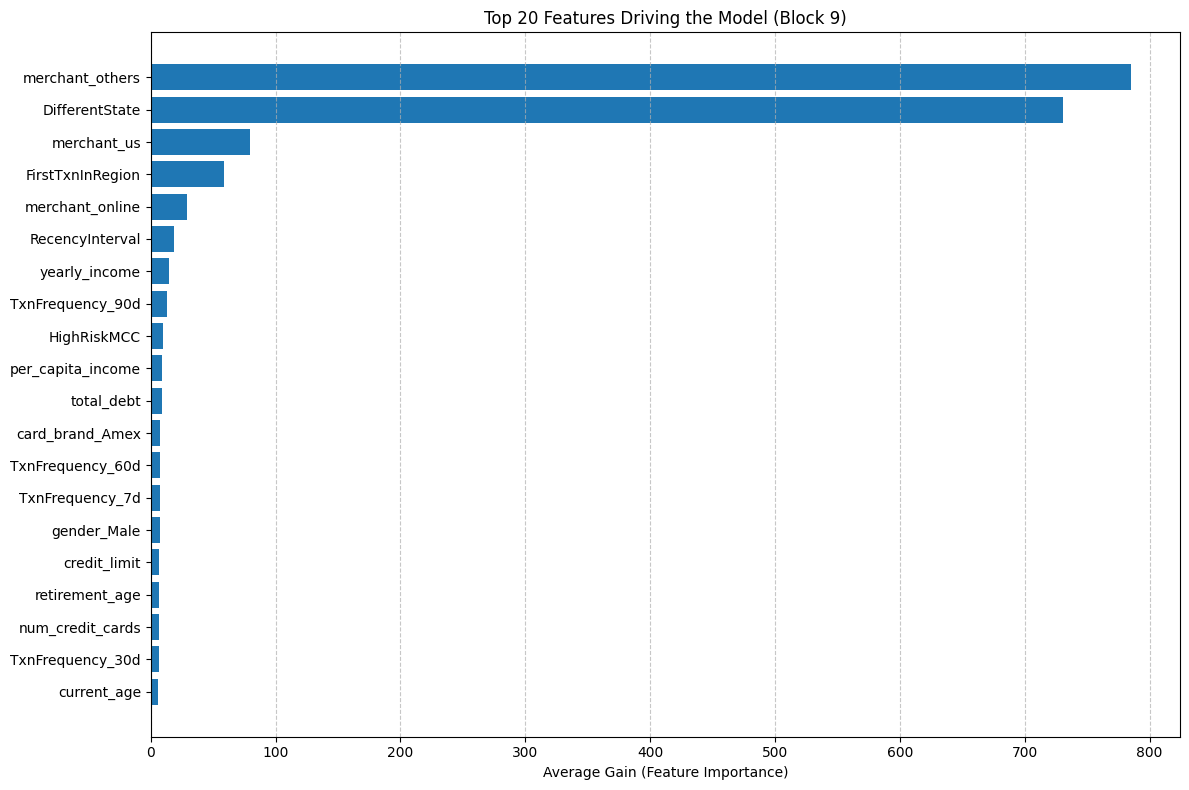

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 自動抓取最後一個 Time Block 的 ID (避免 Key Error)
last_block_id = max(xgb_results.keys())
print(f"正在分析 Time Block {last_block_id} 的特徵重要性...")

# 2. 取出模型
# 確保您使用的 group_name 跟訓練時一致 (例如 'X_all + X_rfm + X_dk')
target_group = 'X_all + X_rfm + X_dk' 

if target_group in xgb_results[last_block_id]:
    model = xgb_results[last_block_id][target_group]['model']
    
    # 3. 取得特徵重要性 (Gain)
    # Gain 代表該特徵在樹的分裂中帶來了多少資訊增益（最準確的指標）
    importance = model.get_booster().get_score(importance_type='gain')
    
    # 轉成 DataFrame
    fi_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
    
    # 排序並取前 20 名
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(20)
    
    print(fi_df)

    # 4. 畫圖
    plt.figure(figsize=(12, 8))
    plt.barh(fi_df['Feature'][::-1], fi_df['Importance'][::-1], color='#1f77b4')
    plt.xlabel('Average Gain (Feature Importance)')
    plt.title(f'Top 20 Features Driving the Model (Block {last_block_id})')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print(f"找不到 {target_group} 的結果，請檢查您的 feature_groups 名稱")

In [22]:
# 檢查 merchant_others 裡面的狀況
print("=== Merchant Others 分析 ===")
mask = df_sorted['merchant_others'] == 1
total = mask.sum()
frauds = df_sorted.loc[mask, 'is_fraud'].sum()

print(f"交易總筆數: {total}")
print(f"詐欺筆數: {frauds}")
print(f"詐欺率 (Fraud Rate): {frauds/total:.2%}")
print("-" * 30)
print("全體平均詐欺率:", df_sorted['is_fraud'].mean())

=== Merchant Others 分析 ===
交易總筆數: 59515
詐欺筆數: 3319
詐欺率 (Fraud Rate): 5.58%
------------------------------
全體平均詐欺率: 0.0014954633014180765


In [ ]:
# ===========================================================
# 4. 自動化執行：Stepwise Features -> XGBoost
# ===========================================================

# 用來存最終 XGBoost 的結果
xgb_stepwise_results = []

# 確保 df_sorted 存在
if 'df_sorted' not in locals():
    raise ValueError("⚠️ Error: 'df_sorted' 未定義")

for block_id, block_df in df_sorted.groupby('time_block'):
    
    current_year = 2010 + block_id
    print(f"\n{'='*60}")
    print(f"🚀 Running XGBoost (w/ Stepwise Feats) for Block {block_id} (Year: {current_year})")
    print(f"{'='*60}")

    # --- 1. 資料切分 (必須與 Stepwise 階段完全一致) ---
    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)
    
    train_raw = block_df.iloc[:split_index].copy()
    test_raw  = block_df.iloc[split_index:].copy()

    # --- 2. 特徵工程 (Anti-Leakage) ---
    try:
        fraud_rate = train_raw.groupby('mcc_code')['is_fraud'].mean()
        high_risk_mcc = fraud_rate[fraud_rate > 0.02].index
        train_raw['HighRiskMCC'] = train_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
        test_raw['HighRiskMCC']  = test_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
    except:
        pass # 若資料為空，後面會被檢查擋下

    # --- 3. 取出該年份 Stepwise 選出的特徵字典 ---
    # 如果該年份完全沒跑 Stepwise (例如報錯)，給一個空字典
    block_feats_dict = stepwise_feature_storage.get(block_id, {})

    # --- 4. 針對每個 Group 跑 XGBoost ---
    for group_name in feature_groups.keys():
        
        # 從字典中取出「該年份、該群組」篩選後的變數列表
        my_features = block_feats_dict.get(group_name, [])
        
        # 檢查 1: 是否有變數被選出
        if not my_features:
            print(f"   ⚠️ Group: {group_name} - Skipped (No features selected by Stepwise)")
            # 存入 NaN 以便報表對齊
            xgb_stepwise_results.append({
                "Year": current_year,
                "Feature Group": group_name,
                "Train AUC": np.nan, "Test AUC": np.nan,
                "Train PR-AUC": np.nan, "Test PR-AUC": np.nan,
                "Num Features": 0
            })
            continue

        print(f"   🔥 Group: {group_name} (Using {len(my_features)} features)...", end=" ")

        # 檢查 2: 執行 XGBoost
        # 注意：這裡傳入的是 my_features (Stepwise 篩選後的結果)
        res = run_xgb_single(
            train_raw, 
            test_raw, 
            feature_cols=my_features, # <--- 關鍵在這裡
            dep_var="is_fraud"
        )

        if res["status"] == "success":
            m = res["metrics"]
            print(f"✅ Test AUC: {m.get('Test AUC', np.nan)}")
            
            xgb_stepwise_results.append({
                "Year": current_year,
                "Feature Group": group_name,
                "Train AUC": m.get("Train AUC"),
                "Test AUC": m.get("Test AUC"),
                "Train PR-AUC": m.get("Train PR-AUC"),
                "Test PR-AUC": m.get("Test PR-AUC"),
                "Num Features": len(my_features)
            })
            
        elif res["status"] == "skip":
            print(f"⚠️ Skipped: {res['message']}")
            xgb_stepwise_results.append({
                "Year": current_year, "Feature Group": group_name,
                "Train AUC": np.nan, "Test AUC": np.nan,
                "Train PR-AUC": np.nan, "Test PR-AUC": np.nan,
                "Num Features": len(my_features)
            })
            
        else:
            print(f"❌ Error: {res['message']}")
            # 視情況決定是否紀錄 Error

print("\n🎉 All XGBoost models completed!")

# ===========================================================
# 5. 產出 XGBoost (Stepwise Features) 最終報表
# ===========================================================
if xgb_stepwise_results:
    df_xgb_raw = pd.DataFrame(xgb_stepwise_results)
    
    # 設定指標
    target_metrics = ["Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]
    
    # 轉置表格 (Pivot)
    df_xgb_pivot = df_xgb_raw.pivot(index="Feature Group", columns="Year", values=target_metrics)
    
    # 調整欄位層級 (Year 在上)
    df_xgb_pivot.columns = df_xgb_pivot.columns.swaplevel(0, 1)
    
    # 排序欄位
    unique_years = sorted(df_xgb_raw["Year"].unique())
    ordered_columns = [(y, m) for y in unique_years for m in target_metrics]
    df_xgb_final = df_xgb_pivot.reindex(columns=ordered_columns)
    
    print("\n=== XGBoost Performance (Using Stepwise Selected Features) ===")
    print(df_xgb_final.to_string())
else:
    print("No results to display.")

df_xgb_final.to_csv("xgb_stepwise.csv") 


🚀 Running XGBoost (w/ Stepwise Feats) for Block 0 (Year: 2010)
   🔥 Group: X_all (Using 6 features)... ✅ Test AUC: 0.9342
   🔥 Group: X_rfm (Using 4 features)... ✅ Test AUC: 0.8148
   🔥 Group: X_dk (Using 4 features)... ✅ Test AUC: 0.969
   🔥 Group: X_all + X_rfm (Using 10 features)... ✅ Test AUC: 0.9533
   🔥 Group: X_all + X_dk (Using 8 features)... ✅ Test AUC: 0.9703
   🔥 Group: X_rfm + X_dk (Using 7 features)... ✅ Test AUC: 0.9758
   🔥 Group: X_all + X_rfm + X_dk (Using 12 features)... ✅ Test AUC: 0.9903

🚀 Running XGBoost (w/ Stepwise Feats) for Block 1 (Year: 2011)
   🔥 Group: X_all (Using 2 features)... ✅ Test AUC: nan
   🔥 Group: X_rfm (Using 1 features)... ✅ Test AUC: nan
   🔥 Group: X_dk (Using 2 features)... ✅ Test AUC: nan
   🔥 Group: X_all + X_rfm (Using 7 features)... ✅ Test AUC: nan
   🔥 Group: X_all + X_dk (Using 3 features)... ✅ Test AUC: nan
   🔥 Group: X_rfm + X_dk (Using 5 features)... ✅ Test AUC: nan
   🔥 Group: X_all + X_rfm + X_dk (Using 7 features)... ✅ Test AUC

## 06-3 Light GBM

### (6-3 a) LGBM function定義

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score

# --- 輔助檢查函數 (防止崩潰) ---
def check_data_validity(y_data, stage="Train"):
    if len(y_data) == 0:
        return False, f"{stage} set is empty"
    if y_data.nunique() < 2:
        val = y_data.iloc[0] if len(y_data) > 0 else "None"
        return False, f"{stage} set has only 1 class (value: {val})"
    return True, ""

# ===========================================================
# 1. 修改後的 LightGBM 訓練函數 (含防呆機制)
# ===========================================================
def run_lgbm_single(train_df, test_df, feature_cols, dep_var="is_fraud"):
    """
    針對 Stepwise 篩選後的特徵訓練 LightGBM，並處理邊界情況 (Edge Cases)
    """
    X_train = train_df[feature_cols]
    y_train = train_df[dep_var]
    X_test  = test_df[feature_cols]
    y_test  = test_df[dep_var]

    # --- 1. 防崩潰檢查 (重要修改) ---
    # 檢查 Train: 若無效 (如全為0)，模型無法學習，直接跳過
    is_valid_train, msg_train = check_data_validity(y_train, "Train")
    if not is_valid_train:
        return {"status": "skip", "message": msg_train}

    # 檢查 Test: 若無效 (只有一類)，模型仍可跑，但 Test Metrics 會是 NaN
    is_valid_test, _ = check_data_validity(y_test, "Test")

    # --- 2. 處理類別不平衡 ---
    pos = y_train.sum()
    neg = len(y_train) - pos
    # 防呆: 雖然前面已經檢查過 validity，但為了保險起見
    spw = neg / pos if pos > 0 else 1

    # --- 3. 初始化模型 ---
    model = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.02,
        max_bin=128,
        scale_pos_weight=spw,
        min_split_gain=1.0,
        reg_alpha=0.1,
        reg_lambda=5,
        min_child_samples=20,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    try:
        # --- 4. 訓練模型 ---
        # 策略：如果測試集無效，我們用訓練集充當 eval_set 防止報錯，
        # 但這時 early_stopping 的意義不大，不過為了代碼一致性我們保留。
        
        if is_valid_test:
            eval_set = [(X_test, y_test)]
        else:
            eval_set = [(X_train, y_train)]

        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        
        model.fit(
            X_train, y_train,
            eval_set=eval_set,
            eval_metric="auc",
            callbacks=callbacks
        )

        # --- 5. 計算指標 ---
        # Train 部分 (通常不會有問題)
        train_pred = model.predict_proba(X_train)[:, 1]
        train_auc = roc_auc_score(y_train, train_pred)
        train_pr  = average_precision_score(y_train, train_pred)

        # Test 部分 (關鍵修改：處理 NaN)
        test_auc = np.nan
        test_pr = np.nan

        if is_valid_test:
            try:
                test_pred = model.predict_proba(X_test)[:, 1]
                test_auc = roc_auc_score(y_test, test_pred)
                test_pr = average_precision_score(y_test, test_pred)
            except ValueError:
                # 萬一發生預測值全為同一類別等極端情況
                pass 

        best_iter = model.best_iteration_ if model.best_iteration_ else 500

        return {
            "status": "success",
            "metrics": {
                "Train AUC": round(train_auc, 4),
                "Test AUC": round(test_auc, 4) if not np.isnan(test_auc) else np.nan,
                "Train PR-AUC": round(train_pr, 4),
                "Test PR-AUC": round(test_pr, 4) if not np.isnan(test_pr) else np.nan,
                "Best Iteration": best_iter
            }
        }
    except Exception as e:
        return {"status": "error", "message": str(e)}


🚀 Running LightGBM for Block 0 (Year: 2010)


KeyboardInterrupt: 

### (6-3 b) Run LGBM

In [ ]:

# ===========================================================
# 2. 主迴圈 (修正 HighRiskMCC 加入方式 & Skip 處理)
# ===========================================================

# ... (前面的 feature_groups 定義都不用動) ...

lgbm_results = {}

for block_id, block_df in df_sorted.groupby('time_block'):
    
    print(f"\n{'='*60}")
    print(f"🚀 Running LightGBM for Block {block_id} (Year: {2010 + block_id})")
    print(f"{'='*60}")

    # --- 資料切分 ---
    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)
    
    train_raw = block_df.iloc[:split_index].copy()
    test_raw  = block_df.iloc[split_index:].copy()

    # --- 重算 HighRiskMCC (Anti-Leakage) ---
    # 這是動態生成的特徵
    fraud_rate = train_raw.groupby('mcc_code')['is_fraud'].mean()
    high_risk_mcc = fraud_rate[fraud_rate > 0.02].index
    
    train_raw['HighRiskMCC'] = train_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
    test_raw['HighRiskMCC']  = test_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')

    lgbm_results[block_id] = {}

    for group_name, feature_list in feature_groups.items():
        
        # 1. 先過濾原本存在的特徵
        valid_features = [f for f in feature_list if f in train_raw.columns]
        
        # ★★★ 修正點 1: 確保動態特徵 HighRiskMCC 被加入 ★★★
        # 如果你希望每個模型都包含這個強特徵，請在這裡手動 append
        if 'HighRiskMCC' not in valid_features:
            valid_features.append('HighRiskMCC')

        if not valid_features:
            continue
            
        print(f"   🔹 Group: {group_name} ({len(valid_features)} features)...", end=" ")

        # 執行 LightGBM
        res = run_lgbm_single(
            train_raw, 
            test_raw, 
            feature_cols=valid_features, 
            dep_var="is_fraud"
        )

        # ★★★ 修正點 2: 優雅地處理 Skip 狀態 ★★★
        if res["status"] == "success":
            metrics = res["metrics"]
            print(f"✅ Done (Best Iter: {metrics['Best Iteration']})")
            lgbm_results[block_id][group_name] = metrics
            
        elif res["status"] == "skip":
            # 遇到資料不足 (例如該年無詐欺)，顯示黃色警告但不報錯
            print(f"⚠️ Skipped: {res['message']}")
            lgbm_results[block_id][group_name] = {"skipped": True, "reason": res['message']}
            
        else:
            # 真正的程式錯誤才顯示 Error
            print(f"❌ Error: {res['message']}")
            lgbm_results[block_id][group_name] = {"error": res['message']}

print("\n🎉 All LightGBM models completed!")

### (6-3 c) LGBM result output

6-3 c **跑完LGBM後的結果**會輸出在資料夾名為<font color=blue>“lgbm_results_wide.csv”</font>的csv檔案當中

In [ ]:
# ==========================================
# 3. 製作 LightGBM 整合報表
# ==========================================
lgbm_data_list = []

for block_id, groups in lgbm_results.items():
    current_year = 2010 + block_id 
    
    for group_name, metrics in groups.items():
        if "error" in metrics:
            continue
            
        row = {
            "Year": current_year,
            "Feature Group": group_name,
            "Train AUC": metrics.get("Train AUC"),
            "Test AUC": metrics.get("Test AUC"),
            "Train PR-AUC": metrics.get("Train PR-AUC"),
            "Test PR-AUC": metrics.get("Test PR-AUC")
        }
        lgbm_data_list.append(row)

df_lgbm_raw = pd.DataFrame(lgbm_data_list)

# --- 轉置與階層化 ---
target_metrics = ["Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]

# 1. Pivot: Index=Feature Group, Cols=Year
df_lgbm_pivot = df_lgbm_raw.pivot(index="Feature Group", columns="Year", values=target_metrics)

# 2. Swaplevel: 讓年份在最上層
df_lgbm_pivot.columns = df_lgbm_pivot.columns.swaplevel(0, 1)

# 3. Reindex: 強制排序 (年份小->大, 指標 Train->Test)
unique_years = sorted(df_lgbm_raw["Year"].unique())
ordered_columns = []
for year in unique_years:
    for metric in target_metrics:
        ordered_columns.append((year, metric))

df_lgbm_final = df_lgbm_pivot.reindex(columns=ordered_columns)

print("\n=== LightGBM 整合結果總表 ===")
print(df_lgbm_final.to_string())

# 如果您在 Jupyter Notebook，可以用這行顯示漂亮的 HTML 表格
# df_lgbm_final.style.format("{:.4f}").background_gradient(cmap='Blues', subset=pd.IndexSlice[:, (slice(None), 'Test AUC')])
df_lgbm_final.to_csv("lgbm_results_wide.csv")


=== LightGBM 整合結果總表 ===
Year                      2010                                        2011                                        2012                                        2013                                        2014                                        2015                                        2016                                        2017                                        2018                                        2019                                  
                     Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC Train AUC Test AUC Train PR-AUC Test PR-AUC
Feature Group                                        

### (6-3 d) LGBM 使用stepwise 版本

6-3 d 用於跑完stepwise features selection 後，直接讀取選完的features來進行LGBM，若要單獨運行此段程式，記得先載好6-3 a的function即可！！
**LGBM 運行stepwise selection的結果**會輸出在資料夾名為<font color=blue>“lgbm_stepwise.csv”</font>的csv檔案當中

In [ ]:
# ===========================================================
# 2. 自動化執行：Stepwise Features -> LightGBM
# ===========================================================

lgbm_stepwise_results = []

# 檢查必要變數
if 'df_sorted' not in locals():
    raise ValueError("⚠️ Error: 'df_sorted' 未定義")
if 'stepwise_feature_storage' not in locals():
    raise ValueError("⚠️ Error: 'stepwise_feature_storage' 未定義，請先執行 Stepwise 步驟。")

# 這裡我們仍需要 feature_groups 的 key (例如 "X_all", "X_rfm") 來跑迴圈
group_names = feature_groups.keys()

for block_id, block_df in df_sorted.groupby('time_block'):
    
    current_year = 2010 + block_id
    print(f"\n{'='*60}")
    print(f"🚀 Running LightGBM (Stepwise Feats) for Block {block_id} (Year: {current_year})")
    print(f"{'='*60}")

    # --- 1. 資料切分 (Split) - 保持一致 ---
    block_df = block_df.sort_values('date')
    split_index = int(len(block_df) * 0.8)
    
    train_raw = block_df.iloc[:split_index].copy()
    test_raw  = block_df.iloc[split_index:].copy()

    # --- 2. 特徵工程 (Anti-Leakage) ---
    try:
        fraud_rate = train_raw.groupby('mcc_code')['is_fraud'].mean()
        high_risk_mcc = fraud_rate[fraud_rate > 0.02].index
        train_raw['HighRiskMCC'] = train_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
        test_raw['HighRiskMCC']  = test_raw['mcc_code'].isin(high_risk_mcc).astype('uint8')
    except:
        pass # 若資料為空，稍後會被 skip

    # --- 3. 讀取該年份的 Stepwise 變數字典 ---
    # 如果該年份完全沒跑出結果 (例如資料太少報錯)，給空字典
    block_feats_dict = stepwise_feature_storage.get(block_id, {})

    # --- 4. 針對每個 Group 執行 ---
    for group_name in group_names:
        
        # ★ 關鍵：從字典取出 Stepwise 篩選後的變數
        my_features = block_feats_dict.get(group_name, [])
        
        # 情況 A: Stepwise 沒選出任何變數 (或該組資料有問題)
        if not my_features:
            print(f"   ⚠️ Group: {group_name} - Skipped (No features from Stepwise)")
            lgbm_stepwise_results.append({
                "Year": current_year, "Feature Group": group_name,
                "Train AUC": np.nan, "Test AUC": np.nan,
                "Train PR-AUC": np.nan, "Test PR-AUC": np.nan,
                "Num Features": 0
            })
            continue

        print(f"   🔹 Group: {group_name} (Using {len(my_features)} feats)...", end=" ")

        # 情況 B: 執行 LightGBM
        res = run_lgbm_single(
            train_raw, 
            test_raw, 
            feature_cols=my_features, # 使用篩選後的變數
            dep_var="is_fraud"
        )

        if res["status"] == "success":
            m = res["metrics"]
            print(f"✅ Test AUC: {m.get('Test AUC', np.nan)}")
            
            lgbm_stepwise_results.append({
                "Year": current_year,
                "Feature Group": group_name,
                "Train AUC": m.get("Train AUC"),
                "Test AUC": m.get("Test AUC"),
                "Train PR-AUC": m.get("Train PR-AUC"),
                "Test PR-AUC": m.get("Test PR-AUC"),
                "Num Features": len(my_features)
            })
            
        elif res["status"] == "skip":
            print(f"⚠️ Skipped: {res['message']}")
            lgbm_stepwise_results.append({
                "Year": current_year, "Feature Group": group_name,
                "Train AUC": np.nan, "Test AUC": np.nan,
                "Train PR-AUC": np.nan, "Test PR-AUC": np.nan,
                "Num Features": len(my_features)
            })
            
        else:
            print(f"❌ Error: {res['message']}")
            # 視需求決定是否紀錄 Error

print("\n🎉 All LightGBM models (Stepwise) completed!")

# ===========================================================
# 3. 產出報表
# ===========================================================
if lgbm_stepwise_results:
    df_lgbm_raw = pd.DataFrame(lgbm_stepwise_results)
    
    # 轉置
    target_metrics = ["Train AUC", "Test AUC", "Train PR-AUC", "Test PR-AUC"]
    df_lgbm_pivot = df_lgbm_raw.pivot(index="Feature Group", columns="Year", values=target_metrics)
    
    # 調整欄位
    df_lgbm_pivot.columns = df_lgbm_pivot.columns.swaplevel(0, 1)
    unique_years = sorted(df_lgbm_raw["Year"].unique())
    ordered_columns = [(y, m) for y in unique_years for m in target_metrics]
    
    df_lgbm_final = df_lgbm_pivot.reindex(columns=ordered_columns)
    
    print("\n=== LightGBM Performance (Using Stepwise Selected Features) ===")
    print(df_lgbm_final.to_string())
else:
    print("No results generated.")


df_lgbm_final.to_csv("lgbm_stepwise.csv") 


🚀 Running LightGBM (Stepwise Feats) for Block 0 (Year: 2010)
   🔹 Group: X_all (Using 6 feats)... ✅ Test AUC: 0.8839
   🔹 Group: X_rfm (Using 4 feats)... ✅ Test AUC: 0.735
   🔹 Group: X_dk (Using 4 feats)... ✅ Test AUC: 0.9515
   🔹 Group: X_all + X_rfm (Using 10 feats)... ✅ Test AUC: 0.9181
   🔹 Group: X_all + X_dk (Using 8 feats)... ✅ Test AUC: 0.9576
   🔹 Group: X_rfm + X_dk (Using 7 feats)... ✅ Test AUC: 0.7709
   🔹 Group: X_all + X_rfm + X_dk (Using 12 feats)... ✅ Test AUC: 0.9282

🚀 Running LightGBM (Stepwise Feats) for Block 1 (Year: 2011)
   🔹 Group: X_all (Using 2 feats)... ✅ Test AUC: nan
   🔹 Group: X_rfm (Using 1 feats)... ✅ Test AUC: nan
   🔹 Group: X_dk (Using 2 feats)... ✅ Test AUC: nan
   🔹 Group: X_all + X_rfm (Using 7 feats)... ✅ Test AUC: nan
   🔹 Group: X_all + X_dk (Using 3 feats)... ✅ Test AUC: nan
   🔹 Group: X_rfm + X_dk (Using 5 feats)... ✅ Test AUC: nan
   🔹 Group: X_all + X_rfm + X_dk (Using 7 feats)... ✅ Test AUC: nan

🚀 Running LightGBM (Stepwise Feats) for

## Optional code--單獨讀取stepwise結果進入code
### (省時間讀stepwise後的結果，用來運行session 6 各d part)

In [2]:
import pickle
with open('stepwise_feature_storage.pkl', 'rb') as f:
     stepwise_feature_storage = pickle.load(f)
print("✅ 已讀取變數設定")

✅ 已讀取變數設定


In [6]:
import pandas as pd

# 1. 確保它是 DataFrame。如果是字典轉過來的，這步會處理好。
df = pd.DataFrame(stepwise_feature_storage)

# 2. 使用 stack() 將欄位「旋轉」下來
# 這會產生一個多重索引 (Year_Index, Model_Type)
stacked = df.stack()

# 3. 轉回 DataFrame 並重整索引
df_final = stacked.reset_index()

# 4. 重新命名欄位
df_final.columns = ['Year', 'Model_Type', 'Features']

# 5. 將 Year 轉換成你想要的 "year_0" 格式
df_final['Year'] = df_final['Year'].apply(lambda x: f"year_{x}")

# 6. 依照年份排序
df_final = df_final.sort_values(by=['Year', 'Model_Type'])

# --- 輸出結果檢查 ---
for _, row in df_final.iterrows():
    print(f"{row['Year']}  {row['Model_Type']}  {row['Features']}")

# --- 儲存 CSV ---
df_final.to_csv('stepwise_features_final.csv', index=False, encoding='utf-8-sig')
print("\n✅ 最終修正版 CSV 已存檔：stepwise_features_final.csv")

year_X_all  0  ['zip', 'longitude', 'use_chip_Swipe Transaction', 'merchant_id', 'amount', 'per_capita_income', 'credit_limit', 'errors_missing_flag', 'mcc_code', 'yearly_income', 'latitude']
year_X_all  1  ['use_chip_Swipe Transaction', 'amount']
year_X_all  2  ['use_chip_Swipe Transaction', 'merchant_id', 'mcc_code', 'credit_limit', 'num_credit_cards', 'errors_missing_flag']
year_X_all  3  ['use_chip_Swipe Transaction', 'yearly_income', 'amount', 'card_type_Credit', 'card_type_Debit', 'merchant_id', 'gender_Male', 'errors_missing_flag', 'credit_score', 'card_brand_Visa']
year_X_all  4  ['use_chip_Swipe Transaction', 'amount', 'credit_limit', 'num_credit_cards', 'retirement_age', 'errors_missing_flag', 'card_brand_Mastercard', 'num_cards_issued', 'current_age', 'longitude', 'per_capita_income', 'card_type_Credit', 'card_type_Debit', 'mcc_code']
year_X_all  5  ['use_chip_Chip Transaction', 'use_chip_Swipe Transaction', 'amount', 'yearly_income', 'num_credit_cards', 'credit_limit', 'has